# Comparativa de NN y algoritmos tradicionales con datos de medicamentos

.

In [111]:
import pandas as pd
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
import tensorview as tv
from tensorflow.keras import losses, metrics,  optimizers, regularizers

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split,ParameterGrid
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import pydotplus
import matplotlib.image as mpimg


## Cargar Datos a partir de un archivo CSV 

In [112]:
df = pd.read_csv('~/Desktop/MLandPython/dataset archive/drug200.csv')
print(df.shape)
df.head()

(200, 6)


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


## Definimos X e y 

In [113]:
## Quito features para intentar bajar la varianza 
vars_dep = ['Age','Sex', 'BP', 'Cholesterol', 'Na_to_K']

X = df[vars_dep].values
X.shape

(200, 5)

In [114]:
## Defino la y
y_label = df.columns[-1]
classes_nb = len(df[y_label].unique())

y = df[y_label]
print(y.shape)
y.unique()

(200,)


array(['drugY', 'drugC', 'drugX', 'drugA', 'drugB'], dtype=object)

## Codificamos la variable de salida
Lo hacemos adaptando a una red neuronal con 1 neurona de salida por cada clase en clasificación

One Hot Encoding

In [115]:
## Encode class values as integers (LabelEncoder)
## Convert integers to dummy variables (OneHotEncoder)
ohe = OneHotEncoder(sparse = False)
le = LabelEncoder()

dummy_y = le.fit_transform(y)
dummy_y = ohe.fit_transform(dummy_y.reshape(-1, 1))
dummy_y[0:10]

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [116]:
# # Con esto se revierten las codificaciones, puedo usarlo con la prediccion
# alreves = ohe.inverse_transform(y)
# alreves = alreves.reshape(1,-1)[0,:]
# alreves = le.inverse_transform(alreves)
# alreves

## Normalizar los Datos 

In [117]:
## Paso las variables categoricas a numeros enteros
#.astype('float32')
le2 = LabelEncoder()
X[:,1] = le2.fit(['F','M']).transform(X[:,1])
X[:,2] = le2.fit(['LOW', 'NORMAL', 'HIGH']).transform(X[:,2])
X[:,3] = le2.fit(['NORMAL', 'HIGH']).transform(X[:,3])

# Si el resultado es peor no lo hago
#X = MinMaxScaler().fit(X).transform(X.astype(float))
X = StandardScaler().fit(X).transform(X.astype(float))
X[0:5]


array([[-1.29159102, -1.040833  , -1.11016894, -0.97043679,  1.28652212],
       [ 0.16269866,  0.96076892,  0.10979693, -0.97043679, -0.4151454 ],
       [ 0.16269866,  0.96076892,  0.10979693, -0.97043679, -0.82855818],
       [-0.988614  , -1.040833  ,  1.32976279, -0.97043679, -1.14996267],
       [ 1.0110343 , -1.040833  ,  0.10979693, -0.97043679,  0.27179427]])

## Aqui separo los datos en train y test


In [118]:
X_train, X_test, y_train, y_test = train_test_split( X, dummy_y, test_size=0.2, random_state=8)
print ('Set de Entrenamiento:', X_train.shape,  y_train.shape)
print ('Set de Prueba:', X_test.shape,  y_test.shape)
X_train.shape

Set de Entrenamiento: (160, 5) (160, 5)
Set de Prueba: (40, 5) (40, 5)


(160, 5)

## Empiezo con modelo de 1 capa

Hago una funcion propia para crear una red neuronal, para poder pasar los params repetidamente y asi optimizar los hiperparámetros

### Aqui creo el modelo

In [119]:
metricNames = ['Categorical cross-entropy', 'Accuracy'] #'sparse_categorical_crossentropy'
metricNamesRaw = ['loss', 'accuracy']

In [120]:
def crea_red_1capa(neuronas=32, activ_entr='relu', activ_sal='softmax', optimiser_mio='adam',
                   epochs_ini=100, batch_ini=16):
    model = Sequential()
    model.add(Dense(neuronas, input_dim = X_train.shape[1], activation=activ_entr))
    model.add(Dense(classes_nb, activation = activ_sal)) 
    model.compile(optimizer = optimiser_mio, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,cell_size=(6,4), columns=2, iter_num=epochs_ini, wait_num=2)
    historyDense0 = model.fit(X_train, y_train,
                    epochs=epochs_ini, batch_size=batch_ini, 
                    validation_data = (X_test, y_test), 
                    verbose=0,
                    #class_weight = class_weight,
                    callbacks=[tvPlot]);
    
    return model

In [121]:
### Primero hago unas pruebas para ver con qué epochs y batch size se consigue una precisión aceptable
## Para luego optimizar los hiperparámetros con algo rápido y bueno


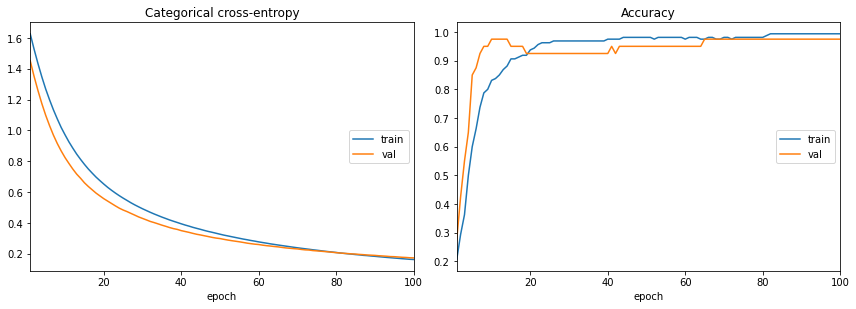

2/2 [==============================] - 0s 3ms/step - loss: 0.1722 - accuracy: 0.9750
Modelo: {'activ_entr': 'tanh', 'optimiser_mio': 'adam'} Precisión: 0.9750000238418579 ✓




In [122]:
## Optimizo los hiperparámetros
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {#'epochs_ini':[100, 50],
                 #'batch_ini':[8, 16], 
                 'activ_entr': ['relu','selu','tanh'],
                 'optimiser_mio'   : ['adam']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'accuracy': []}

for params in param_grid:
    
    model_1L = crea_red_1capa(**params)
    test_loss, test_acc = model_1L.evaluate(X_test, y_test)
    
    resultados['params'].append(params)
    resultados['accuracy'].append(test_acc)
    print(f"Modelo: {params} Precisión: {test_acc} \u2713")
    print("\n")
    
# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados = resultados.reset_index(drop=True)

In [123]:
resultados.head(7)

,accuracy,activ_entr,optimiser_mio
0,0.975,selu,adam
1,0.975,tanh,adam
2,0.950,relu,adam


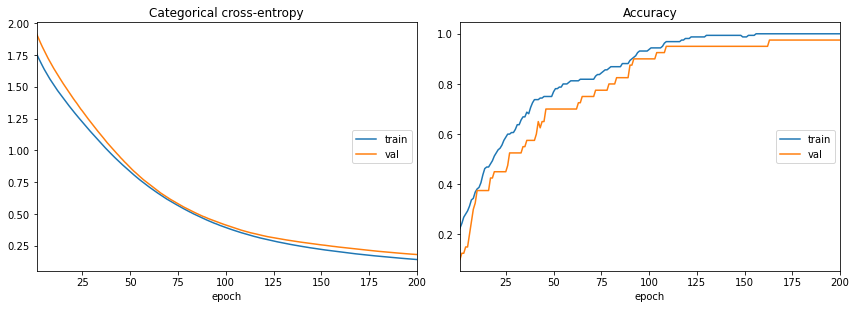

In [129]:
#Entreno el modelo final con los parámetros mejores que he optimizado
model_1L8 = crea_red_1capa(neuronas=8, epochs_ini=200, batch_ini=16)

In [130]:
dummy_ypred_1 = model_1L8.predict(X_train)
dummy_yhat_1 = model_1L8.predict(X_test)
print("Precisión de entrenamiento: ", accuracy_score(np.argmax(y_train,axis=1), np.argmax(dummy_ypred_1, axis=1)))
print("Precisión de test: ", accuracy_score(np.argmax(y_test, axis=1), np.argmax(dummy_yhat_1, axis=1)))


Precisión de entrenamiento:  1.0
Precisión de test:  0.975


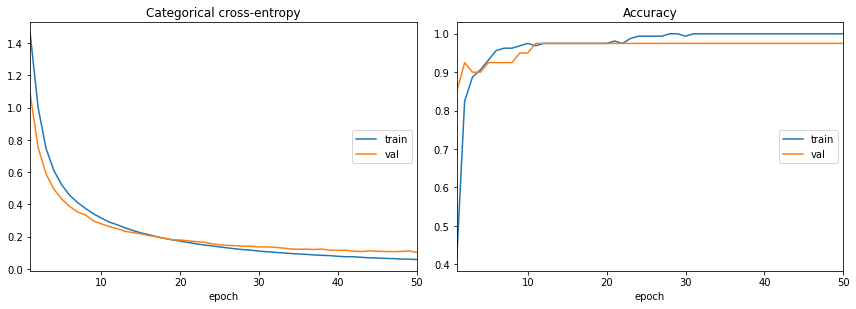

In [131]:
model_1L512 = crea_red_1capa(neuronas=512, epochs_ini=50, batch_ini=16, activ_entr='selu')

In [132]:
# train_loss, train_acc = model_1L.evaluate(X_train, y_train)
# print("Train accuracy", train_acc)
# test_loss, test_acc = model_1L.evaluate(X_test, y_test)
# print("Test accuracy", test_acc)

# Evaluacion del modelo de mi cosecha para ambos
dummy_ypred_1 = model_1L512.predict(X_train)
dummy_yhat_1 = model_1L512.predict(X_test)
print("Precisión de entrenamiento: ", accuracy_score(np.argmax(y_train,axis=1), np.argmax(dummy_ypred_1, axis=1)))
print("Precisión de test: ", accuracy_score(np.argmax(y_test, axis=1), np.argmax(dummy_yhat_1, axis=1)))
#print('params: ', resultados.at[0,'activ_entr'], resultados.at[0,'activ_sal'])


Precisión de entrenamiento:  1.0
Precisión de test:  0.975


In [133]:
#Matriz del modelo de 1 capa
print("Modelo de 1 capa\n")
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(dummy_yhat_1, axis=1), labels=range(0,classes_nb)))
print (classification_report(np.argmax(y_test, axis=1), np.argmax(dummy_yhat_1, axis=1)))


Modelo de 1 capa

[[ 5  0  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  2  0  0]
 [ 0  0  0 12  0]
 [ 0  0  0  1 17]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       0.92      1.00      0.96        12
           4       1.00      0.94      0.97        18

    accuracy                           0.97        40
   macro avg       0.98      0.99      0.99        40
weighted avg       0.98      0.97      0.98        40




## Ahora con modelo de 3 capas

  

In [138]:
def crea_red_3capa(neuronas= 32, activ_entr='relu', activ_hid='relu', activ_sal='softmax',
                 optimiser_mio='adam',epochs_ini=100, batch_ini=16):
    model = Sequential()
    model.add(Dense(neuronas, input_dim = X_train.shape[1], activation=activ_entr))
    model.add(Dense(neuronas, activation=activ_hid))
    model.add(Dense(neuronas, activation=activ_hid))
    model.add(Dense(classes_nb, activation = activ_sal)) 
    model.compile(optimizer = optimiser_mio, loss='categorical_crossentropy', metrics=['accuracy'])
    
    tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,cell_size=(6,4), columns=2, iter_num=epochs_ini, wait_num=2)
    historyDense1 = model.fit(X_train, y_train,
                    epochs=epochs_ini, batch_size=batch_ini, 
                    validation_data = (X_test, y_test), 
                    verbose=0,
                    #class_weight = class_weight,
                    callbacks=[tvPlot]);

    return model

In [139]:
# ## Primero hago unas pruebas para ver con qué epochs y batch size se consigue una precisión aceptable
# # Para luego optimizar los hiperparámetros con algo rápido y bueno

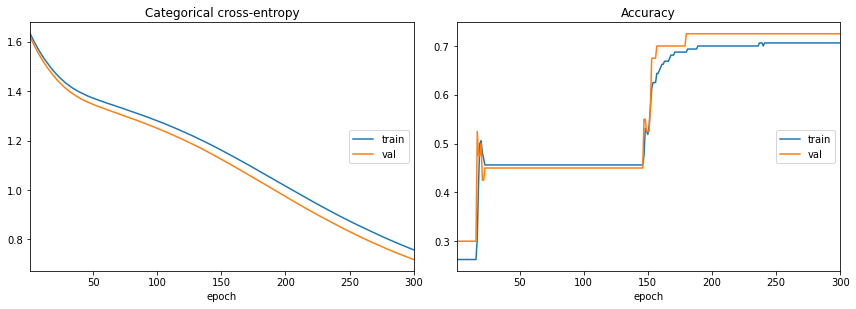

2/2 [==============================] - 0s 2ms/step - loss: 0.7185 - accuracy: 0.7250
Modelo: {'batch_ini': 16, 'epochs_ini': 300, 'neuronas': 2} ✓


In [157]:
## Optimizo los hiperparámetros
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'neuronas':[8, 4, 2],
                 'epochs_ini':[200, 300],
                 'batch_ini':[8, 16], 
                 #'activ_entr': ['relu','selu','tanh'],
                 #'activ_hid'   : ['relu','sigmoid'],
                 #'activ_sal'   : ['softmax'],
                 #'optimiser_mio'   : ['adam']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'accuracy': []}

for params in param_grid:
    
    model_3L = crea_red_3capa(activ_entr='selu',activ_hid='sigmoid', **params)
    test_loss, test_acc = model_3L.evaluate(X_test, y_test)
    
    resultados['params'].append(params)
    resultados['accuracy'].append(test_acc)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados = resultados.reset_index(drop=True)

In [159]:
resultados.head(12)

,accuracy,batch_ini,epochs_ini,neuronas
0,0.925,8,300,8
1,0.900,8,200,8
2,0.875,8,200,4
3,0.875,16,200,8
4,0.875,16,300,8
5,0.875,16,300,4
6,0.850,8,300,4
7,0.750,8,200,2
8,0.725,16,200,4
9,0.725,16,200,2


In [150]:
# Entreno el modelo final con los parámetros mejores que 
# model_3L = crea_red_3capa(activ_entr = resultados.at[0,'activ_entr'],
#                           activ_hid = resultados.at[0,'activ_hid'],
#                           activ_sal = resultados.at[0,'activ_sal'],
#                           optimiser_mio = resultados.at[0,'optimiser_mio'],
#                           epochs_ini=100, 
#                           batch_ini=16)

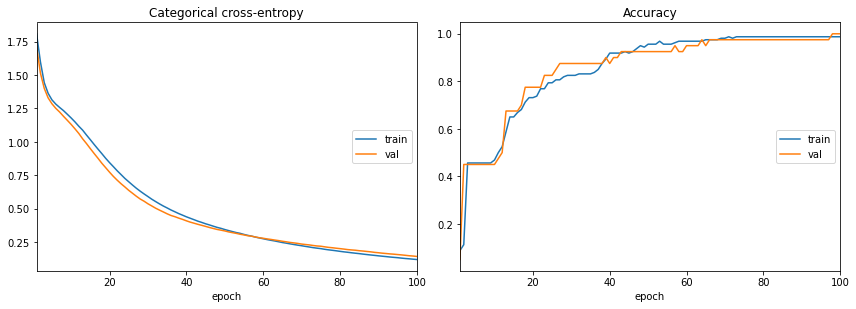

In [151]:
# La red de 3 capas con 32 neuronas llega al 100% de acierto
model_3L32 = crea_red_3capa(neuronas=32, 
                            activ_entr = 'selu',
                            activ_hid = 'sigmoid',
                            activ_sal = 'softmax',
                            optimiser_mio = 'adam',
                            epochs_ini=100, 
                            batch_ini=16)

In [161]:
# Evaluacion del modelo para ambos
dummy_ypred_3 = model_3L32.predict(X_train)
dummy_yhat_3 = model_3L32.predict(X_test)
print("Precisión de entrenamiento: ", accuracy_score(np.argmax(y_train, axis=1), np.argmax(dummy_ypred_3, axis=1)))
print("Precisión de test: ", accuracy_score(np.argmax(y_test, axis=1), np.argmax(dummy_yhat_3, axis=1)))  

Precisión de entrenamiento:  0.9875
Precisión de test:  1.0


In [162]:
#Matriz del modelo de 3 capas
print("Modelo de 3 capas\n")
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(dummy_yhat_3, axis=1), labels=range(0,classes_nb)))
print (classification_report(np.argmax(y_test, axis=1), np.argmax(dummy_yhat_3, axis=1)))


Modelo de 3 capas

[[ 5  0  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  2  0  0]
 [ 0  0  0 12  0]
 [ 0  0  0  0 18]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00        18

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



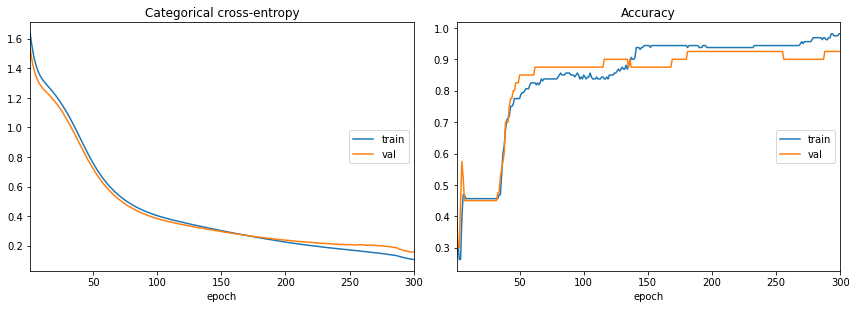

In [163]:
# La red de 3 capas con 8 neuronas llega al 92.5% de acierto
model_3L8 = crea_red_3capa(neuronas=8, 
                           activ_entr = 'selu',
                           activ_hid = 'sigmoid',
                           activ_sal = 'softmax',
                           optimiser_mio = 'adam',
                           epochs_ini=300, 
                           batch_ini=8)

In [164]:
# Evaluacion del modelo para ambos
dummy_ypred_3 = model_3L8.predict(X_train)
dummy_yhat_3 = model_3L8.predict(X_test)
print("Precisión de entrenamiento: ", accuracy_score(np.argmax(y_train, axis=1), np.argmax(dummy_ypred_3, axis=1)))
print("Precisión de test: ", accuracy_score(np.argmax(y_test, axis=1), np.argmax(dummy_yhat_3, axis=1)))
  

Precisión de entrenamiento:  0.98125
Precisión de test:  0.925


In [165]:
print(model_3L32.summary())
print(model_3L8.summary())

Model: "sequential_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_252 (Dense)            (None, 32)                192       
_________________________________________________________________
dense_253 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_254 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_255 (Dense)            (None, 5)                 165       
Total params: 2,469
Trainable params: 2,469
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_134"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_332 (Dense)            (None, 8)                 48        
_____________________